In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from helper import *

# Adaptive Control


### Summary:
* We describe a very naive adaptive control strategy
* We walk through the implementation of said strategy
* We test out the strategy on different systems and compare performance

### Overview

A one sentence summary of what adaptive control aims to answer is the following: how can you control a system whose parameters you don't know for certain? That is, suppose we had a linear time invariant (LTI) system of the form

$$x_{t+1} =  Ax_t + Bu_t $$
$$ y_t = x_t$$

and we want to control the system to $x_T = 0$ after $T$ time steps. If we knew $(A,B)$, we could use the Linear Quadratic Regulator (LQR). But if you don't know $(A,B)$ what do you do?

This is by no means a solved problem but a lot of research has been done on different strategies and methods to tackle these sorts of problem. In this notebook, we'll try out a simple strategy, see when it works and doesn't work, and walk through the implementation process.

### Simple Strategy

We could simply use our best estimate of $(A,B)$ at a given time $t < T$ - call it $(\hat{A}_t,\hat{B}_t)$ - and pretend that they are actually the correct values. Then solve the LQR problem using $(\hat{A}_t,\hat{B}_t)$ while continually updating our estimates of $(A,B)$. More specifically,

At $t= 0$, set $y_0 = x_0 = \bar{x}$ as starting point and input $u_0 \sim \mathcal{N}(0,\sigma^2 I)$ and observe $y_1$\
$\textbf{for}$ $t=1,...,T$
* Calculate $(\hat{A}_t, \hat{B}_t)$ via Least Squares using the trajectory up until time $t$ &mdash; $\{ (u_i,y_i) \}_{i=0}^{t-1}$
* Solve a 10-horizon LQR problem using $(\hat{A}_t, \hat{B}_t)$ to get $\{u_i^\ast\}_{t=1}^{10}$
* Apply $u_1^\ast$ to the true system and observe $y_t$

### Implementation

Let's implement the above procedure and see how it performs.

#### Step 1 &mdash; Calculate $(\hat{A}_t, \hat{B}_t)$

The function below takes in a trajectory up until time $t-1$ and outputs $(\hat{A}_t, \hat{B}_t)$

In [217]:
def system_identification(u ,y):
    # code a function that takes in a list
    # of inputs (u) and outputs (y) and 
    # returns a least squares estimate of (A,B)
    # using the method dervied in the worksheet
    
    
    ### YOUR CODE HERE ###
    all_ys = []
    all_us = []
    all_inputys=[]
    for i in range(len(u)):

        y1 = np.concatenate((y[i],np.zeros(y[i].shape)),axis=None)
        y2 = np.concatenate((np.zeros(y[i].shape),y[i]),axis=None)
        each_y = np.vstack((y1,y2))
        all_ys += [each_y]

        u1 = np.concatenate((u[i],np.array([0])),axis=None)
        u2 = np.concatenate((np.array([0]),u[i]),axis=None)
        each_u = np.vstack((u1,u2))
        all_us += [each_u]
        
        all_inputys+=[y[i+1]]

    Y = np.vstack(all_ys)
    U = np.vstack(all_us)
    Z = np.hstack(all_inputys)

    A= Y.T@Y
    B= Y.T@U
    C= Y.T@Z
    D= U.T@U
    E= U.T@Y
    F= U.T@Z

    vec_b_opt = np.linalg.pinv(np.linalg.pinv(A)@B-np.linalg.pinv(E)@D)@(np.linalg.pinv(E)@F-np.linalg.pinv(A)@C)
    vec_a_opt = np.linalg.pinv(np.linalg.pinv(B)@A-np.linalg.pinv(D)@E)@(np.linalg.pinv(D)@F-np.linalg.pinv(B)@C)

    Ahat = vec_a_opt.reshape((2,2))
    Bhat = vec_b_opt.reshape((2,1))
    
    return Ahat, Bhat

#### Step 2 &mdash; Solve 1-horizon LQR problem using $(\hat{A}_t, \hat{B}_t)$

We solve the finite horizon LQR problem using the Discrete Algebraic Riccati Equations (DARE). 

In [159]:
def optimal_control(A, B, Q, R, y0, t = 1):
    # solve LQR problem with A,B given using
    # discrete time algebraic ricatti equations

    n, m = B.shape[0], B.shape[1]

    Pt = [Q]
    for i in range(t):
        BPBR_inv = np.linalg.inv(B.T @ Pt[i] @ B+ R)
        Pt.append(Q + A.T @ Pt[i] @ A -
                  A.T @ Pt[i] @ B @ BPBR_inv @ B.T @ Pt[i] @ A)
    Pt.reverse()
    
    ut = []
    yt = [y0]
    for i in range(t):
        BPBR_inv = np.linalg.inv(B.T @ Pt[0] @ B + R)
        ut.append(-BPBR_inv @ B.T @ Pt[i] @ A @ yt[i])
        yt.append(A @ yt[i] + B @ ut[i])
        
    return ut


#### Step 3 &mdash; Simulate real system usig control from Step 2

We take $u_t[0]$ from the output of the $\texttt{optimal_control}$ method and run the $\texttt{simulate_system}(y0, u_t[0])$ method from helper.py

### Experiments

We consider the two following systems; System 1

$$x_{t+1} = \begin{bmatrix} 1 & 1\\ 0 & 1 \end{bmatrix} x_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} u_t$$

$$y_t = x_t$$

and System 2

$$ x_{t+1} = \begin{bmatrix} 0 & 1\\ 0 & 0 \end{bmatrix} x_t + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_t$$

$$y_t = x_t$$

The systems are written out explicitly above but we **do not have access** to them. All we have access is to is the output of each system $y_t$ when we feed in $u_t$. In the real world, we have a system where we havent modeled the dynamics (we don't know the true inner workings of the system), but all we're allowed to do is feed the system inputs and observe the output. Since we are running a synthetic simulation, we are artifically creating the true system (with the equations given above) but in order to simulate our procedure as if it were in the real world, **we assume** that we can only observe an output $y_t$ when we input $u_t$. This is captured by the $\texttt{simulate_system}$ function in the helper file.

We will now implement our naive strategy on both systems and see how we do. We fix the time horizon of the problem (not LQR) to $T=20$. That is, we will simulate the system for 20 steps with the controls based on our naive strategy. For both systems, try the two initial conditions $y_0 = [1,0]$ and $y_0 = [1,1]$ and start with a random initial input ($u_0 \sim \mathcal{N}(0,1)$) to get the system started (note this is the only randomness in the simulation). For simplicity, we'll fix $Q = I_2$ and $R = 1$ for the LQR problem. 

In [249]:
n, m, T = 2, 1, 20                   #2 states, 1 input, 30 time steps
y0 = np.array([1,1])                 #initial state
u0 = np.array(np.random.randn(m))    #random initial input
states, controls = [y0], [u0]        #list of states and controls
y1 = simulate_system(y0, u0, 1)      #start off the system
states.append(y1)

Q, R = np.eye(n), np.eye(m)
At, Bt = [], []

# Jointly do system identification and control
for i in range(T):
    
    # system identification
    A_hat, B_hat = system_identification(controls,states)
    
    At.append(A_hat)
    Bt.append(B_hat)
    y1 = A_hat@y1 + B_hat@ u0
    states.append(y1)
    
    # optimal control and simulate real system
    u0 = optimal_control(A_hat, B_hat, Q, R, y1, t = 1)[0]
    controls.append(u0)

We are interested in answering the following two questions for each initial condition for each system 
* Does $(\hat{A}_t,\hat{B}_t) \rightarrow (A,B)$? 
* Does $y_t \rightarrow [0, 0]$ indicating the system has converged to an equilibrium?

In [254]:
At[-1], Bt[-1] #No, does not converge

(array([[0.03277919, 0.08445624],
        [0.01342663, 0.03459399]]),
 array([[0.62148194],
        [1.38887401]]))

Text(0, 0.5, 'position')

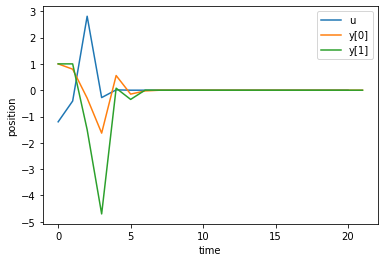

In [255]:
### YOUR ANSWER HERE ###

plt.plot(controls,label='u')
plt.plot(np.array(states)[:,0],label='y[0]')
plt.plot(np.array(states)[:,1],label='y[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')

#yt does converge

#### From the above graph we can see that yt does in deed converge to zero, and the system converges to an equilibrium. However, A_hat and B_hat did not seem to converge to A and B indicated in the beginning of the problem. 

### Open-ended question

Now we restrict our attention to the following system:

$$x_{t+1} = \begin{bmatrix} 1 & 1\\ 0 & 1.99 \end{bmatrix} x_t + \begin{bmatrix} 1 \\ 1 \end{bmatrix} u_t$$
$$ y_t = x_t $$

The goal of this section is to see if you can come up with a method for which $(\hat{A}_t,\hat{B}_t) \rightarrow (A,B)$ and $y_t \rightarrow [0,0]$ **for all** initial conditions $y_0$ (since this is an empirical problem, we'll be satisfied if the method works for 1000 random initial conditions $y_0 \sim \mathcal{N}(0, 10 \cdot I_2)$). Compare how your method compares with running LQR on the problem assuming you knew the system dynamics. 

There is by no means a *correct* answer. This portion is intended to be open ended and for you to try out any ideas you have (or to implement ideas from research papers). While there is a plethora of research in this area, below are some references that may be of interest:

[1] Regret Bounds for Robust Adaptive Control of the Linear Quadratic Regulator (Dean et al, 2018) <br />
[2] Finite Time Adaptive Stabilization of LQ Systems (Faradonbeh et al, 2018) <br />
[3] Optimal adaptive control of Linear-Quadratic-Gaussian systems (Kumar, 1983) <br />
[4] A survey of some results in stochastic adaptive control (Kumar, 1985) <br />


Albert Einstein once said "If we knew what it was we were doing, it would not be called research, would it?"